In [2]:
import numpy as np
import pandas as pd
from skimage import io as skio
from aicsfeature import extractor

import matplotlib.pyplot as plt

from skimage.transform import resize

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(seg, zoom=0.1):
    return OffsetImage(seg.max(axis=0),zoom=zoom)

def display_time_series(result, variable, imgs, channel=(0,1)):
    x = list(range(result.shape[0]))
    y = result[variable]

    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.plot(x, y, "-o")
    
    artists = []
    for x0, y0, img in zip(x, y, imgs):
        ab = AnnotationBbox(getImage(img["data"][channel[0]]["img"][channel[1]]), (x0, y0), frameon=False)
        artists.append(ax.add_artist(ab))
    plt.ylabel(variable)
    plt.show()

### Introduction

This notebook is used to validate the aics-ferature module. This module implements many hand-crafted features used in different projects:

* QCB
* Integrated nucleus

### Load data

We used the average cell data created in the mitotic alignment project. This data represents a simple and standardize set of shapes that make the features more interpretable.

In [3]:
STAGES = ["M1","M2","M3","M4","M5","M6","M7"]

dataset = []
for stage in STAGES:
    img_seg = skio.imread("/home/matheus.viana/shared/forGrahamAlignMitotic/aligned_by_dna_maxp/"+stage+"/avg_cell_seg.ome.tif")
    img_raw = skio.imread("/home/matheus.viana/shared/forGrahamAlignMitotic/aligned_by_dna_maxp/"+stage+"/avg_cell_raw.ome.tif")
    img_seg[img_seg<7] = 0
    img_seg[img_seg>0] = 1
    img_raw = img_raw * img_seg

    img_seg = np.swapaxes(np.swapaxes(np.swapaxes(img_seg,2,3),1,2),0,1)
    img_raw = np.swapaxes(np.swapaxes(np.swapaxes(img_raw,2,3),1,2),0,1)
    
    imgs = []
    for seg, raw, channel in zip(img_seg,img_raw,["cell","dna","structure"]):
       
        new_z = np.int((0.29/0.108)*seg.shape[0])
        new_y = seg.shape[1]
        new_x = seg.shape[2]

        seg = resize(image = seg, output_shape = (new_z, new_y, new_x), order = 0, preserve_range = True, anti_aliasing = False, mode = "constant")
        raw = resize(image = raw, output_shape = (new_z, new_y, new_x), order = 0, preserve_range = True, anti_aliasing = False, mode = "constant")

        imgs.append({"channel": channel, "img": (raw,seg)})
        
    dataset.append({"stage": stage, "data": imgs})

We load the aics-feature module everytime there is a change in the package without having to reload the data

In [62]:
import importlib
importlib.reload(extractor)

<module 'aicsfeature.extractor' from '/home/matheus.viana/sources/aics-feature/aicsfeature/extractor.py'>

### Shape features

In [34]:
result = []
for i, stage in enumerate(STAGES):
    f = extractor.get_shape_features(seg=dataset[i]["data"][0]["img"][1])
    result.append(f)
result = pd.DataFrame(result)
result.head()

,shape_1st_axis_length,shape_1st_axis_x,shape_1st_axis_y,shape_1st_axis_z,shape_1st_eigenvalue,shape_2nd_axis_length,shape_2nd_axis_x,shape_2nd_axis_y,shape_2nd_axis_z,shape_2nd_eigenvalue,shape_3rd_axis_length,shape_3rd_axis_x,shape_3rd_axis_y,shape_3rd_axis_z,shape_3rd_eigenvalue,shape_equator_eccentricity,shape_meridional_eccentricity,volume
0,216.159225,0.980818,0.192331,0.031698,403.139912,196.407939,0.193352,-0.980572,-0.033070,1857.329423,85.101927,-0.024722,-0.038564,0.998950,2150.730998,0.217054,0.863581,1816909
1,229.316782,0.992930,-0.107103,0.051167,418.023960,176.588453,-0.105522,-0.993880,-0.032672,1348.826599,86.354164,-0.054354,-0.027042,0.998156,2555.915913,0.309917,0.527727,1722373
2,202.467400,0.771270,-0.636506,0.001741,506.974060,190.026612,-0.636257,-0.771039,-0.025987,1780.881742,97.026762,-0.017883,-0.018935,0.999661,1957.394220,0.284676,0.909823,1931543
3,238.647231,0.999692,0.007630,-0.023605,494.126367,183.984991,-0.007589,0.999970,0.001818,1699.006444,98.041266,0.023619,-0.001638,0.999720,2532.120224,0.290833,0.670982,2134694
4,219.452766,0.999389,0.011454,-0.033036,484.180708,175.778188,-0.010853,0.999773,0.018334,1630.387767,94.487489,0.033238,-0.017964,0.999286,2510.137546,0.296973,0.649521,2056269


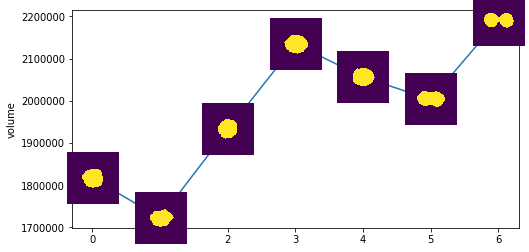

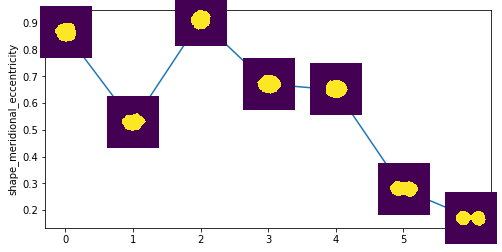

In [35]:
display_time_series(result=result, variable="volume", imgs=dataset, channel=(0,1))
display_time_series(result=result, variable="shape_meridional_eccentricity", imgs=dataset, channel=(0,1))

### Roundness Features

In [37]:
result = []
for i, stage in enumerate(STAGES):
    f = extractor.get_roundness_features(seg=dataset[i]["data"][0]["img"][1])
    result.append(f)
result = pd.DataFrame(result)
result.head()

,roundness_roughness,roundness_roughness_xy,roundness_roughness_xz,roundness_roughness_yz,roundness_sphericity,surface_area
0,16.485562,5.705120,20.859548,18.449089,0.772711,139848.0
1,17.276638,11.733963,24.882169,14.173517,0.784368,132950.0
2,14.000638,3.349368,17.548005,15.750752,0.811579,138692.0
3,16.460874,8.062446,23.207344,15.768139,0.823874,146038.0
4,16.291492,7.610704,21.392060,13.919960,0.846261,138672.0


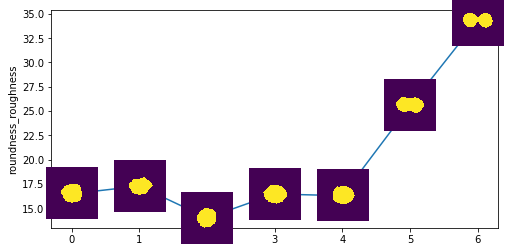

In [38]:
display_time_series(result=result, variable="roundness_roughness", imgs=dataset, channel=(0,1))

### Position Features

In [39]:
result = []
for i, stage in enumerate(STAGES):
    f = extractor.get_position_features(seg=dataset[i]["data"][0]["img"][1])
    result.append(f)
result = pd.DataFrame(result)
result.head()

,position_highest_z,position_lowest_z,position_x_centroid,position_y_centroid,position_z_centroid
0,216,134,256.150715,255.787798,175.811805
1,213,131,258.993520,256.339655,174.198445
2,219,123,256.508478,253.358139,174.126240
3,219,123,258.244060,256.615690,174.038566
4,221,126,258.191720,255.013820,173.824615


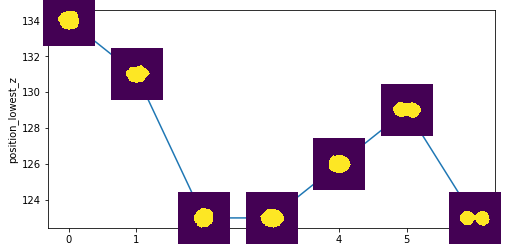

In [40]:
display_time_series(result=result, variable="position_lowest_z", imgs=dataset, channel=(0,1))

### Intensity Features

In [42]:
result = []
for i, stage in enumerate(STAGES):
    f = extractor.get_intensity_features(img=dataset[i]["data"][1]["img"][0].astype(np.uint16))
    result.append(f)
result = pd.DataFrame(result)
result.head()

,intensity_entropy,intensity_max,intensity_mean,intensity_median,intensity_mode,intensity_std,intensity_sum
0,6.338711,4846,4404.436130,4419.0,4502,141.368251,3314201650
1,6.444086,6200,5537.818091,5544.0,5566,154.596285,2176417888
2,6.793554,5806,4934.550147,4931.0,4925,220.466062,959424585
3,7.537117,8009,6326.972249,6304.0,6320,473.268126,1246653958
4,7.583771,8182,6682.218060,6669.0,6516,493.585050,1337425898


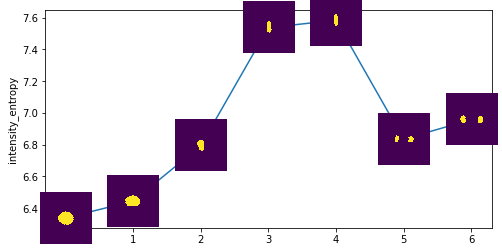

In [43]:
display_time_series(result=result, variable="intensity_entropy", imgs=dataset, channel=(1,1))

### Skeleton Features

In [46]:
result = []
for i, stage in enumerate(STAGES):
    f, _ = extractor.get_skeleton_features(seg=dataset[i]["data"][2]["img"][0])
    result.append(f)
result = pd.DataFrame(result)
result.head()

,skeleton_deg0_prop,skeleton_deg1_prop,skeleton_deg3_prop,skeleton_deg4p_prop,skeleton_degree_mean,skeleton_edges_number,skeleton_nodes_number,skeleton_voxels_number
0,0.000216,0.041261,0.078926,0.879597,9.731374,383022,78719.0,110058
1,0.000150,0.047599,0.106564,0.845687,9.584276,350357,73111.0,106482
2,0.000198,0.049934,0.175031,0.774837,9.514991,264198,55533.0,88848
3,0.000225,0.054629,0.204151,0.740995,9.444340,272549,57717.0,98835
4,0.000119,0.026595,0.137358,0.835929,9.503557,400047,84189.0,120453


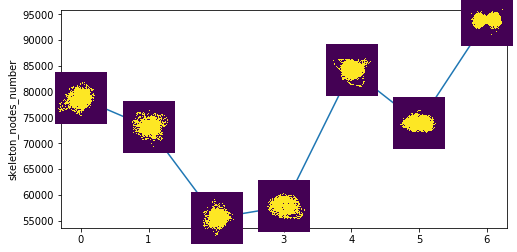

In [47]:
display_time_series(result=result, variable="skeleton_nodes_number", imgs=dataset, channel=(2,1))

### Texture Features

In [26]:
info = {
    "distances": [5],
    "scaling_params": [0.5, 18]
}

result = []
for i, stage in enumerate(STAGES):
    f, _ = extractor.get_texture_features(img=dataset[i]["data"][1]["img"][0], params=info)
    result.append(f)
result = pd.DataFrame(result)
result.head()

,texture_distance_used,texture_haralick_ang2nd_moment,texture_haralick_contrast,texture_haralick_corr,texture_haralick_diff_entropy,texture_haralick_diff_var,texture_haralick_entropy,texture_haralick_info_corr1,texture_haralick_info_corr2,texture_haralick_inv_diff_moment,texture_haralick_sum_entropy,texture_haralick_sum_mean,texture_haralick_sum_var,texture_haralick_variance
0,[5],[0.0023530499502239033],[34.116576402373056],[0.6501496111846703],[3.6433716458925187],[0.00036081779978095174],[9.199031070297131],[-0.08784617456418092],[0.7402432993146439],[0.20291146366172638],[5.652335342280727],[464.5622650676289],[161.58095203982353],[48.92438211055168]
1,[5],[0.0028284934595447053],[36.86518717351579],[0.5003952379708114],[3.7026455332607577],[0.00034067546003038675],[9.022475566693135],[-0.053613555590636415],[0.6047726225261255],[0.19166762136360443],[5.414325893077303],[455.89093953089616],[110.99750156919337],[36.96567218567697]
2,[5],[1.0],[0.0],[1.0],[0.0],[0.0038909912109375],[0.0],[0.0],[0.0],[1.0],[0.0],[510.0],[0.0],[0.0]
3,[5],[0.9856243836499288],[0.15595475232274844],[0.05306356609293516],[0.08365751068892482],[0.0038351611473752436],[0.09326209533376233],[-0.03384020702095046],[0.051059746244765364],[0.9941159018824709],[0.08459597645929116],[509.97147077146553],[0.1724693127885425],[0.08210601627853556]
4,[5],[0.9721851528909787],[0.3675958508037098],[0.08838698826859528],[0.1506817916233367],[0.003783206252955425],[0.17070685981527206],[-0.037359005022642354],[0.07171948574697345],[0.9885324079707589],[0.15336980042381593],[509.9384911639996],[0.4365346599862768],[0.2010326276996728]


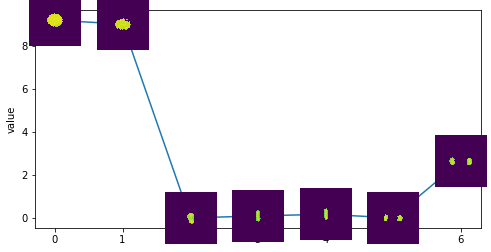

In [32]:
result_new = []
for index in result.index:
    result_new.append({"value": result.at[index,"texture_haralick_entropy"][0]})
result_new = pd.DataFrame(result_new)
display_time_series(result=result_new, variable="value", imgs=dataset, channel=(1,0))

### Dispersion Features

In [21]:
info = {
    "normalize": "True",
    "number_of_samples": 5,
    "repetitions": 5
}

result = []
for i, stage in enumerate(STAGES):
    f, _ = extractor.get_dispersion_features(image1_seg=dataset[i]["data"][0]["img"][1], image2_seg=dataset[i]["data"][1]["img"][1], params=info)
    result.append(f)
result = pd.DataFrame(result)
result.head()

Params: True 5 5
Params: True 5 5
Params: True 5 5
Params: True 5 5
Params: True 5 5
Params: True 5 5
Params: True 5 5


,dispersion_control,dispersion_cost_control,dispersion_cost_data,dispersion_cost_local_control,dispersion_cost_local_data,dispersion_data,dispersion_local_control,dispersion_local_data
0,0.284287,0.557736,0.482005,0.436382,0.367661,0.212609,0.157765,0.146336
1,0.287262,0.541574,0.451221,0.414365,0.381066,0.104146,0.206526,0.094911
2,0.261807,0.539750,0.511955,0.428869,0.434927,0.145080,0.190318,0.117808
3,0.191641,0.499162,0.492728,0.392658,0.418262,0.167553,0.116936,0.136239
4,0.213565,0.507504,0.532563,0.413904,0.443464,0.189947,0.164119,0.142841


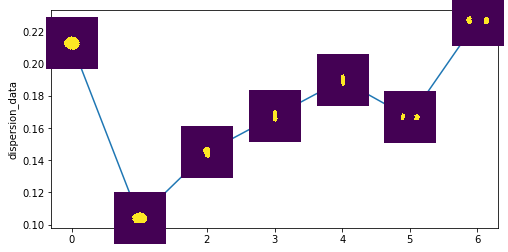

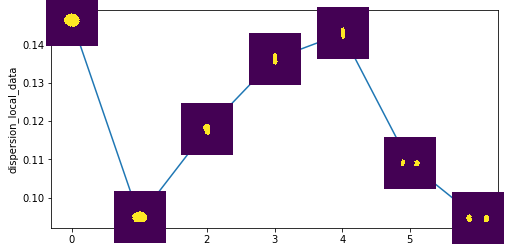

In [25]:
display_time_series(result=result, variable="dispersion_data", imgs=dataset, channel=(1,1))
display_time_series(result=result, variable="dispersion_local_data", imgs=dataset, channel=(1,1))

# Nucleus project-specific features

### IO Intensity Features

In [51]:
result = []
for i, stage in enumerate(STAGES):
    f, _ = extractor.get_io_intensity_features(img=dataset[i]["data"][1]["img"][0], params=["None"])
    result.append(f)
result = pd.DataFrame(result)
result.head()

Params: [1, 4, 4, 4] [2, 4]
Params: [1, 4, 4, 4] [2, 4]
Params: [1, 4, 4, 4] [2, 4]
Params: [1, 4, 4, 4] [2, 4]
Params: [1, 4, 4, 4] [2, 4]
Params: [1, 4, 4, 4] [2, 4]
Params: [1, 4, 4, 4] [2, 4]


,io_intensity_inner_mean,io_intensity_inner_slice_mean,io_intensity_inner_volume,io_intensity_outer_mean,io_intensity_outer_slice_mean,io_intensity_outer_volume
0,4462.425950,4505.721510,136232,4319.369288,4391.183532,200743
1,5613.289054,5656.093960,12489,5542.576124,5602.384960,211083
2,5163.247329,5271.958724,19185,4880.388435,4946.212230,85762
3,6707.507195,7073.544218,37524,6067.801548,6340.858650,67190
4,7139.983408,7362.294511,42068,6398.369406,6596.462607,70034


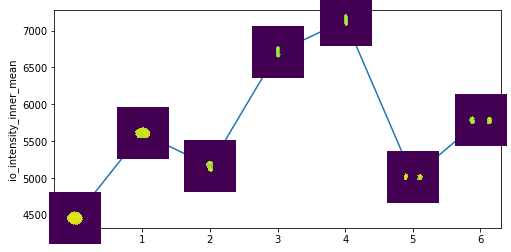

In [52]:
display_time_series(result=result, variable="io_intensity_inner_mean", imgs=dataset, channel=(1,0))

### Bright Spots

In [53]:
result = []
for i, stage in enumerate(STAGES):
    f, _ = extractor.get_bright_spots_features(img=dataset[i]["data"][1]["img"][0], params=["None"])
    result.append(f)
result = pd.DataFrame(result)
result.head()

Params: 1 11 0.85 [0.5, 18]
Params: 1 11 0.85 [0.5, 18]
Params: 1 11 0.85 [0.5, 18]
Params: 1 11 0.85 [0.5, 18]
Params: 1 11 0.85 [0.5, 18]
Params: 1 11 0.85 [0.5, 18]
Params: 1 11 0.85 [0.5, 18]


,bright_spots_intensity_mean,bright_spots_number,bright_spots_number_used,bright_spots_xy_cross_sec_area_mean,bright_spots_xy_cross_sec_area_std
0,4421.302668,2,2,269.0,260.000000
1,5366.225186,21,17,94.0,132.172347
2,4661.265497,45606,5,8.2,5.979967
3,NaN,0,0,NaN,NaN
4,NaN,0,0,NaN,NaN


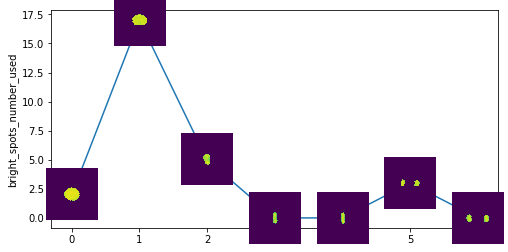

In [54]:
display_time_series(result=result, variable="bright_spots_number_used", imgs=dataset, channel=(1,0))

In [101]:
importlib.reload(extractor)

info={"mode": "lcc",
      "prefix": "dna",
      "shape": {"default": 0},
     "dispersion": {"normalize": "True", "repetitions": 5}}

result = extractor.get_features(input_img=dataset[6]["data"][1]["img"][0],
                                 input_mask=dataset[6]["data"][1]["img"][1],
                                 info=info,
                                input_mask2=dataset[6]["data"][0]["img"][1])
result

   dna_shape_1st_axis_length_lcc  dna_shape_1st_axis_x_lcc  \
0                      77.393315                  0.101609   

   dna_shape_1st_axis_y_lcc  dna_shape_1st_axis_z_lcc  \
0                  0.992207                 -0.072124   

   dna_shape_1st_eigenvalue_lcc  dna_shape_2nd_axis_length_lcc  \
0                    107.823646                       71.56521   

   dna_shape_2nd_axis_x_lcc  dna_shape_2nd_axis_y_lcc  \
0                  0.381779                  -0.10584   

   dna_shape_2nd_axis_z_lcc  dna_shape_2nd_eigenvalue_lcc  \
0                 -0.918173                    258.413091   

              ...              dna_shape_volume_lcc  dna_dispersion_control  \
0             ...                          133285.0                0.135602   

   dna_dispersion_cost_control  dna_dispersion_cost_data  \
0                      0.21715                   0.61434   

   dna_dispersion_cost_local_control  dna_dispersion_cost_local_data  \
0                           0.136311 

,dna_shape_1st_axis_length_lcc,dna_shape_1st_axis_x_lcc,dna_shape_1st_axis_y_lcc,dna_shape_1st_axis_z_lcc,dna_shape_1st_eigenvalue_lcc,dna_shape_2nd_axis_length_lcc,dna_shape_2nd_axis_x_lcc,dna_shape_2nd_axis_y_lcc,dna_shape_2nd_axis_z_lcc,dna_shape_2nd_eigenvalue_lcc,...,dna_shape_volume_lcc,dna_dispersion_control,dna_dispersion_cost_control,dna_dispersion_cost_data,dna_dispersion_cost_local_control,dna_dispersion_cost_local_data,dna_dispersion_data,dna_dispersion_local_control,dna_dispersion_local_data,dna_connectivity_number_cc
0,77.393315,0.101609,0.992207,-0.072124,107.823646,71.56521,0.381779,-0.10584,-0.918173,258.413091,...,133285.0,0.135602,0.21715,0.61434,0.136311,0.343631,0.413805,0.054801,0.350193,2


In [71]:
pd.DataFrame(result).sum()

shape_1st_axis_length                77.393315
shape_1st_axis_x                      0.101609
shape_1st_axis_y                      0.992207
shape_1st_axis_z                     -0.072124
shape_1st_eigenvalue                107.823646
shape_2nd_axis_length                71.565210
shape_2nd_axis_x                      0.381779
shape_2nd_axis_y                     -0.105840
shape_2nd_axis_z                     -0.918173
shape_2nd_eigenvalue                258.413091
shape_3rd_axis_length                48.494264
shape_3rd_axis_x                     -0.918651
shape_3rd_axis_y                      0.065759
shape_3rd_axis_z                     -0.389558
shape_3rd_eigenvalue                320.088755
shape_equator_eccentricity            0.417253
shape_meridional_eccentricity         0.807317
shape_volume                     133285.000000
dtype: float64

In [73]:
(np.array([1,2,3,4,5,5,4,3,2,1])==5).astype(np.uint8)

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=uint8)